In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA
from scipy.io import savemat

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import os
import neptune
from neptune.utils import stringify_unsupported
from sklearn.preprocessing import StandardScaler

import scalpDeepModels as sdm

import importlib

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [2]:
patient = 'UFSEEG031'
targetScalpElectrodes = ['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4']
mode = 'Sleep'

#stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta_%s_%s_%s.npz' % (patient, targetScalpElectrodes, mode)
#timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain_%s_%s_%s.npz' % (patient, targetScalpElectrodes, mode)
#timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta_%s_%s_%s.npz' % (patient, targetScalpElectrodes, mode)

timeDomainSavePath = "/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain_UFSEEG031_['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4']_Wake.npz"

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [6]:
epochs = 5000
batch_size = 1024
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 5000

# UTILITY FUNCTIONS

In [3]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

# LOAD NUMPY DATA ARRAYS

In [4]:
dataSwitch = 'time'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

trainXTensor.shape, trainYTensor.shape, validXTensor.shape, validYTensor.shape

(torch.Size([0]),
 torch.Size([0]),
 torch.Size([22596, 5655]),
 torch.Size([22596, 10]))

In [8]:
# CREATE PYTORCH DATALOADERS

try:
    trainDataset = TensorDataset(trainXTensor,trainYTensor)
    trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

    print("train: ")
    for X, y in trainDataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    validFlag = False
except:
    validFlag = True
    print("No training dataset...")
    
try:    
    validDataset = TensorDataset(validXTensor,validYTensor)
    validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)

    print("\nvalidation: ")
    for X, y in validDataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
        
    validFlag = True
except:
    validFlag = False
    print("No validation dataset...")

No training dataset...

validation: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 10]) torch.float32


# DEFINE THE MODEL FOR TRAINING

In [ ]:
# DEFINE MODEL

importlib.reload(sdm) # reload in case we've made any architecture changes

modelID = np.random.randint(0, 10**6)

# DEFINE ARCHITECTURE HERE
inputSize = trainXTensor.shape[1]
outputSize = trainYTensor.shape[1]
hiddenLayerSizes = [512,512,512,512,512,512]

nnStructure = [inputSize] + hiddenLayerSizes + [outputSize]
layerDict = sdm.listToOrderedDict_1(nnStructure)

#layerDict = sdm.residualAddDict(inputSize, 512, 5)
#layerDict = sdm.residualConcatDict(inputSize, hiddenLayerSizes)

model = nn.Sequential(layerDict)
bestTestLoss = float('inf')
    
print("Model ID: " + str(modelID))
print("Number of parameters: ", sdm.count_parameters(model))
model = model.to(device)
print(model)

# TRAIN (LOG DATA TO NEPTUNE)

In [ ]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "modelID": modelID,
    "targetScalpElectrodes": str(targetScalpElectrodes),
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model),
    "numParameters": sdm.count_parameters(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

#epochs = 2

try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = sdm.train(trainDataLoader, model, loss_fn, optimizer, device)
        test_loss = sdm.test(validDataLoader, model, loss_fn, device)

        if test_loss < bestTestLoss:
            noImprovementCount = 0
            bestTestLoss = test_loss
            
            model_scripted = torch.jit.script(model) 
            model_scripted.save(modelPath + 'model_%s.pt' % str(modelID))
    
            run["best_test_loss"] =  bestTestLoss
            run["best_test_epoch"] = t
            print("\nSaved a new best model!\n")
        else:
            noImprovementCount = noImprovementCount + 1

        run["train/loss"].append(train_loss)
        run["test/loss"].append(test_loss)

        if noImprovementCount >= patience:   
            print("Early stopping invoked....")
            break

    run.stop()
    print("Done!")
except:
    run.stop()
    print("Training aborted...")

# LOAD SAVED MODEL (TORCHSCRIPT) FOR INFERENCE

In [9]:
modelID = '59169'

model = torch.jit.load(modelPath + 'model_%s.pt' % str(modelID))
if validFlag:
    bestTestLoss = sdm.test(validDataLoader, model, loss_fn, device)

Test Error: 
 Avg loss: 0.287180 



# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


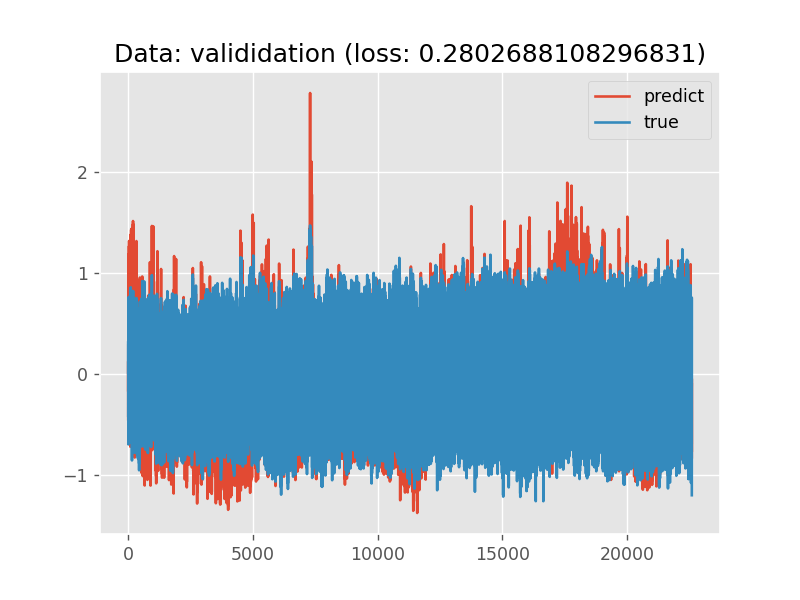

In [10]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = False
scalpElectrodeName = 'F7'

scalpIndex = targetScalpElectrodes.index(scalpElectrodeName)
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'

model.to('cpu')
predict = model(x).cpu().detach().numpy()
model.to(device)

yPred = predict[:,scalpIndex]
if trainPlotFlag:
    yTrue = yTrainTimeDomain[:,scalpIndex]
else:
    yTrue = yValidTimeDomain[:,scalpIndex]

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

In [ ]:
# SAVE yTRUE and yPRED for conversion to EDF

arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/predictionResults/numpy/results_31_Wake_ME1.npz'
np.savez(arraySavePath, yTrue=yTrue, yPred=yPred)

In [ ]:
# SAVE TO .MAT FILES

matSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/predictionResults/matlab/validDataset_31_wake.mat'

mDict = {'prediction':predict, 
         'true' :yValidTimeDomain, 
         'columnOrder':str(['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4'])}
savemat(matSavePath, mDict)

# GET BEST MODEL DATA FROM NEPTUNE

In [ ]:
sdm.neptuneBestRun()

# SCRATCH

In [ ]:
if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

In [ ]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

In [ ]:
from scipy.signal import get_window
a = get_window(('tukey', .25), nperseg)
a

In [ ]:
'''
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('bn%s' % str(i), nn.BatchNorm1d(sizeList[i])))
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
'''

'''
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = sdm.listToOrderedDict(layerSizeList)
    model = sdm.NeuralNetwork(layerOrderedDict)
    '''